In [22]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline
import csv 

In [28]:
with open('test.csv','r') as csvfile:
    reader=csv.reader(csvfile)
    dataset=[row[1] for row in reader]
    dataset=np.array(dataset).astype(np.float)
# fig=plt.figure(figsize=(20,10),dpi=1000)
# ll=plt.plot(rows[0:1000],linewidth=1.2,color='b')
# plt.show()
# fig.savefig('10000.png')
# print(len(rows))

print(dataset[0:10])

[ 56.  64.  48.  45.  42.  49.  42.  33.  45.  37.]


In [24]:
def random_data(size, length=100):
    """
    随机生成数据
    :param size:
    :param length:
    :return:
    """
    data = []
    for _ in range(size):
        x = np.random.random(length) 
        data.append(x)
    return np.array(data)

def preprocess_data(x):
    """
    计算每一组数据平均值和方差
    :param x:
    :return:
    """
    return [[np.mean(data), np.std(data)] for data in x]

In [35]:
###########搭建网络
LENGTH=200
x = tf.placeholder(tf.float32, shape=[None, 400], name="feature")  # [mean，std] -》 D
y = tf.placeholder(tf.float32, shape=[None, 1], name="label")
in_size = LENGTH
out_size = LENGTH
###################################### G  网络结构
# 第一层
z = tf.placeholder(tf.float32, shape=[None, LENGTH], name="noise")  # 随机值噪音
Weights = tf.Variable(tf.random_normal([in_size, 32]))
biases = tf.Variable(tf.zeros([1, 32]) + 0.1)
G_output = tf.matmul(z, Weights) + biases
G_output = tf.nn.relu(G_output)
# 第二层
Weights2 = tf.Variable(tf.random_normal([32, 32]))
biases2 = tf.Variable(tf.zeros([1, 32]) + 0.1)
G_output2 = tf.matmul(G_output, Weights2) + biases2
G_output2 = tf.nn.sigmoid(G_output2)
# 第三层
Weights3 = tf.Variable(tf.random_normal([32, out_size]))
biases3 = tf.Variable(tf.zeros([1, out_size]) + 0.1)

G_output3 = tf.matmul(G_output2, Weights3) + biases3

G_PARAMS = [Weights, biases, Weights2, biases2, Weights3, biases3]  # G的参数

###################################### D 网络结构(预训练的D)
# 第一层

dWeights = tf.Variable(tf.random_normal([400, 32]), name="D_W")
dbiases = tf.Variable(tf.zeros([1, 32]) + 0.1, name="D_b")
D_output = tf.matmul(x, dWeights) + dbiases
D_output = tf.nn.relu(D_output)
# 第二层
dWeights2 = tf.Variable(tf.random_normal([32, 32]), name="D_W2")
dbiases2 = tf.Variable(tf.zeros([1, 32]) + 0.1, name="D_b2")   
D_output2 = tf.matmul(D_output, dWeights2) + dbiases2
D_output2 = tf.nn.sigmoid(D_output2)

# 第三层
dWeights3 = tf.Variable(tf.random_normal([32, 1]), name="D_W3")
dbiases3 = tf.Variable(tf.zeros([1, 1]) + 0.1, name="D_b3")
D_output3_ = tf.matmul(D_output2, dWeights3) + dbiases3
D_output3 = tf.nn.sigmoid(D_output3_)

D_PARAMS = [dWeights, dbiases,
            dWeights2, dbiases2,
            dWeights3, dbiases3]

##################################### GAN的结构



# 先求出G_output3的各行平均值和方差
# print(G_output3.shape)
# MEAN = tf.reduce_mean(G_output3, 1)  # 行向量,求各行平均
# print(MEAN.shape)
# MEAN_T = tf.transpose(tf.expand_dims(MEAN, 0))  # 转置
# print(MEAN_T.shape)
# STD = tf.sqrt(tf.reduce_mean(tf.square(G_output3 - MEAN_T), 1))
# DATA = tf.concat([MEAN_T,tf.transpose(tf.expand_dims(STD, 0))],1)
# print(DATA.shape)以上内容没懂


# GAN中的D
GAN_Weights = tf.Variable(tf.random_normal([200, 32]), name="GAN_W")
GAN_biases = tf.Variable(tf.zeros([1, 32]) + 0.1, name="GAN_b")
#GAN_output = tf.matmul(DATA, GAN_Weights) + GAN_biases
GAN_output = tf.matmul(G_output3, GAN_Weights) + GAN_biases
GAN_output = tf.nn.relu(GAN_output)
# 第二层
GAN_Weights2 = tf.Variable(tf.random_normal([32, 32]), name="GAN_W2")
GAN_biases2 = tf.Variable(tf.zeros([1, 32]) + 0.1, name="GAN_b2")
GAN_output2 = tf.matmul(GAN_output, GAN_Weights2) + GAN_biases2
GAN_output2 = tf.nn.sigmoid(GAN_output2)

# 第三层
GAN_Weights3 = tf.Variable(tf.random_normal([32, 1]), name="GAN_W3")
GAN_biases3 = tf.Variable(tf.zeros([1, 1]) + 0.1, name="GAN_b3")
GAN_output3_ = tf.matmul(GAN_output2, GAN_Weights3) + GAN_biases3
GAN_output3 = tf.nn.sigmoid(GAN_output3_)

GAN_D_PARAMS = [GAN_Weights, GAN_biases,
                GAN_Weights2, GAN_biases2,
                GAN_Weights3, GAN_biases3]

(?, 200)
(?,)
(?, 1)
(?, 2)


In [36]:
##################################### 定义损失函数
d_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=D_output3_, logits=y))  # 二分类交叉熵
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=GAN_output3_, logits=y))  # GAN二分类交叉熵

In [37]:
#################################### 定义优化器
d_optimizer = tf.train.GradientDescentOptimizer(0.01).minimize(
    d_loss,
    global_step=tf.Variable(0),
    var_list=D_PARAMS
)

g_optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(
    g_loss,
    global_step=tf.Variable(0),
    var_list=G_PARAMS
)

In [39]:
d_loss_history = []
g_loss_history = []
epoch = 100
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    # GAN博弈开始
    print('train GAN....')
    for step in range(epoch):
        # 先进行GAN中的D的训练，即对生成样本的判断
        for step1 in range(200):
            # 使用G生成一批样本:
            real =(np.array(dataset[step*200:(step+1)*200]))
            noise = random_data(1,200)
            generate = sess.run(G_output3, feed_dict={z: noise})  # 生成样本
            X = list(real) + list(generate)  
            #X = preprocess_data(X)
            Y = [[1] for _ in range(len(real))] + [[0] for _ in range(len(generate))]
            d_loss_value, _ = sess.run([d_loss, d_optimizer], feed_dict={x: X, y: Y})# 训练判别网络
            d_loss_history.append(d_loss_value)
        # 将参数移动过去GAN中的判别网络
        dp_value = sess.run(D_PARAMS)
        for i, v in enumerate(GAN_D_PARAMS):
            sess.run(v.assign(dp_value[i]))

        for _ in range(200):
            noise = random_data(1,200)
            g_loss_value, _ = sess.run([g_loss, g_optimizer], feed_dict={
                z: noise,
                y: [[1] for _ in range(len(noise))]  # 混肴为目标,不需要加入x，我们只是借助G，并不需要训练G
            })  # 调整G，让GAN的误差减少
            g_loss_history.append(g_loss_value)
        if step % 10 == 0 or step+1 == epoch:
            noise = random_data(1,length=LENGTH)
            generate = sess.run(G_output3, feed_dict={
                z: noise
            })
            print("[%4d] GAN-d-loss: %.12f  GAN-g-loss: %.12f   generate-mean: %.4f   generate-std: %.4f" % (step,
                            d_loss_value, g_loss_value,generate.mean() ,generate.std() ))


    print("train finish...")

train GAN....


ValueError: setting an array element with a sequence.

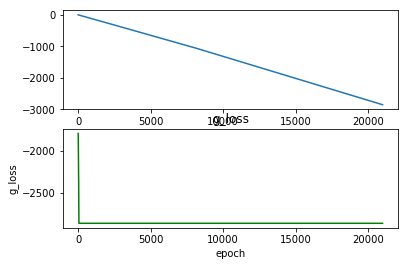

In [21]:
plt.subplot(211)
plt.plot(d_loss_history,label='d_loss')
a = plt.subplot(212)
plt.plot(g_loss_history,c="g")
tt=plt.title("g_loss")
lx = plt.xlabel("epoch")
ly = plt.ylabel("g_loss")

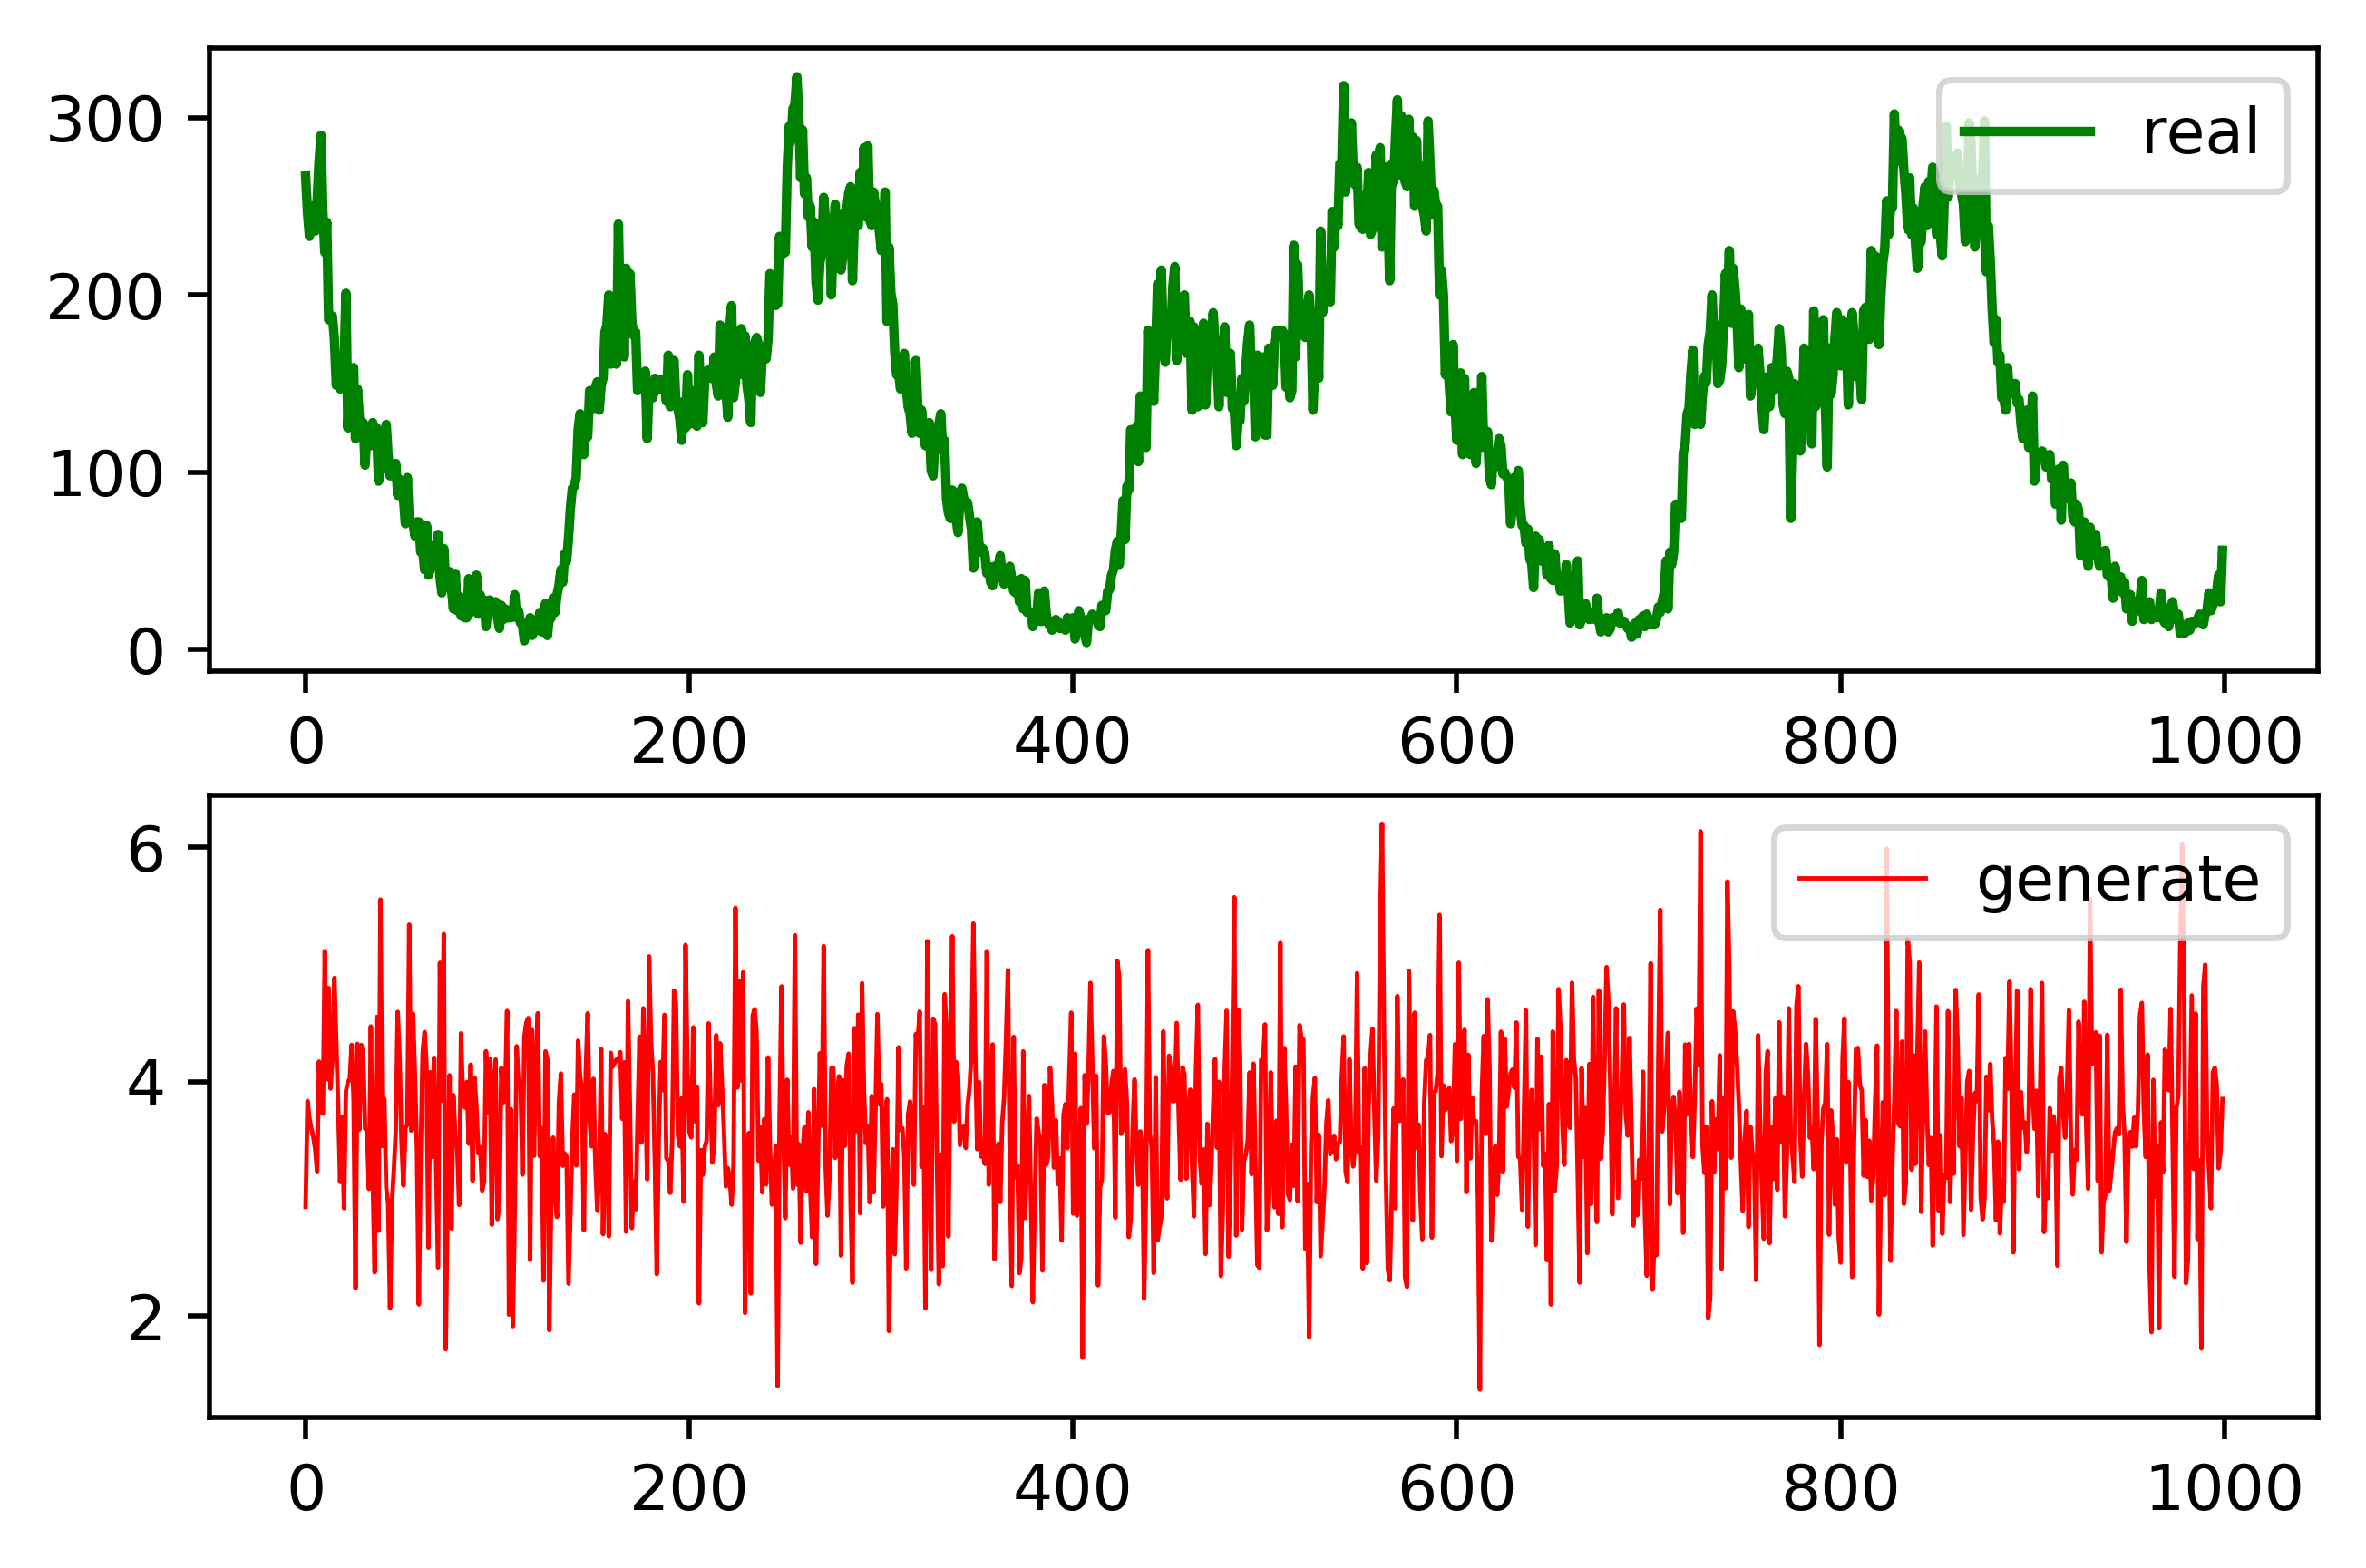

In [18]:
figure=plt.figure(dpi=500)
real =(np.array(dataset[500:1500]))
plt.subplot(211)
plt.plot(real, c="g",label='real')
ll = plt.legend(loc='upper right')
# (data, bins) = np.histogram(noise[0])
# plt.plot(bins[:-1], data, c="b",label='noise')

(data, bins) = np.histogram(generate[0])
plt.subplot(212)
plt.plot(generate[0], c="r",label='generate',linewidth = 0.7)

ll = plt.legend(loc='upper right')
